# Analyzing the Recurrence of Significant Flood Events in New Jersey and the Impact of Climate Change on Flood Recurrence

A quick note on citations: Since formatting footnotes is difficult in a Jupyter Notebook, rather than using a superscripted number to format footnotes, I will use a parenthetical formatted as (Source [number]) to format all footnotes.

### Introduction

Floods are the deadliest meteorological phenomena in the United States, and in recent years, extreme flooding has been recorded with increased frequency across the United States, notably during Hurricane Harvey in Texas (2017), Hurricane Ida and its remnants in Louisiana and the Northeast (2021), the April 2023 Fort Lauderdale floods, and the atmospheric river sequence in the US West Coast this past winter (2022-23) (Source 1), among other significant flood events. In New Jersey, recent major flood events have been associated with Tropical Storm Irene (2011), Hurricane Sandy (2012), Tropical Storm Isaias (2020), and the remnants of Hurricane Ida (2021). I will examine 75 years of hydrological data at three stream/river stations in New Jersey (from 1947 to 2022). Though not fully exhaustive or reflective of New Jersey's hydrology and geography, these three stations are intended to represent each of the various regions in New Jersey (northern, central, and southern), and the various moving water body types of New Jersey (a stream, a creek, and a river). In this project, I seek to contextualize the magnitude of recent flooding events across New Jersey by calculating the exceedance probability of the most significant annual flood event at the station, and its associated recurrence interval. In my discussion and analysis of the results, I use the binomial probability formula to determine the likelihood of the sequence of extreme flooding events recorded at these stations.

I use three datasets for this project. Each dataset contains mean daily stream/river discharge from 1947 to 2022 for each hydrologic station. Stream flow is measured roughly every 5-30 minutes to calculate each of these daily means (Source 2). Rather than downloading the data onto my laptop from the USGS site (which I found to be a convoluted and difficult process), I will use the hydrofunctions Python library (Source 3) to access the data directly from this Jupyter notebook. Though this library wasn't covered in class, I independently read the documentation for this library in order to apply it to these datasets. Note that I still downloaded and included the data separately in my submitted folder. The methods of my analysis were based on information from the USGS and guidelines from the Interagency Committee on Water Data (Source 4).

The idea for this project was inspired by discussions of hydrology and stream flow in EPS 50 this semester, and my general interest in meteorology and local climatology (the reason I chose New Jersey is because it is my home state).

### Scientific Context

At a given location, a the threshold for a 100-year flood is defined as a flood of a magnitude that has a 1% chance of being exceeded in any given year. The '100-year' in the 100-year flood is known as the recurrence interval, and the 1% probability is known as the exceedence probability. This definition of a 100-year flood means that it is possible for two 100-year floods to occur two years in a row, but the probability of such an event would be 0.01%. (Source 5)

### Importing Relevant Libraries and Datasets

In [ ]:
import os
import urllib
import requests
import math
import cartopy.crs as ccrs
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import scipy.stats as stats
import pandas as pd
import hydrofunctions as hf

<em> Importing Daily Mean Discharge Data for Three Sites </em>

In [ ]:
sr_lodi = hf.NWIS('01391500', 'dv', '1947-01-01', '2022-12-31')
sr_lodi_discharge = sr_lodi.df('discharge')
sr_lodi_discharge.columns = ['discharge']
sr_lodi_discharge.to_csv(r'\Saddle River at Lodi.csv', index=False)
sr_lodi_discharge = sr_lodi_discharge.dropna()
sr_lodi_discharge.head()

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01391500&startDT=1947-01-01&endDT=2022-12-31


,discharge
datetimeUTC,
1947-01-01 00:00:00+00:00,50.0
1947-01-02 00:00:00+00:00,49.0
1947-01-03 00:00:00+00:00,50.0
1947-01-04 00:00:00+00:00,52.0
1947-01-05 00:00:00+00:00,49.0


In [ ]:
rr_manville = hf.NWIS('01400500', 'dv', '1947-01-01', '2022-12-31')
rr_manville_discharge = rr_manville.df('discharge')
rr_manville_discharge.columns = ['discharge']
rr_manville_discharge.to_csv(r'\Raritan River at Manville.csv', index=False)
rr_manville_discharge = rr_manville_discharge.dropna()
rr_manville_discharge.head()

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01400500&startDT=1947-01-01&endDT=2022-12-31


,discharge
datetimeUTC,
1947-01-01 00:00:00+00:00,256.0
1947-01-02 00:00:00+00:00,185.0
1947-01-03 00:00:00+00:00,299.0
1947-01-04 00:00:00+00:00,358.0
1947-01-05 00:00:00+00:00,280.0


In [ ]:
ac_absecon = hf.NWIS('01410500', 'dv', '1947-01-01', '2022-12-31')
ac_absecon_discharge = ac_absecon.df('discharge')
ac_absecon_discharge.columns = ['discharge']
ac_absecon_discharge.to_csv(r'\Absecon Creek at Absecon.csv', index=False)
ac_absecon_discharge = ac_absecon_discharge.dropna()
ac_absecon_discharge.head()

Requested data from https://waterservices.usgs.gov/nwis/dv/?format=json%2C1.1&sites=01410500&startDT=1947-01-01&endDT=2022-12-31


,discharge
datetimeUTC,
1947-01-01 00:00:00+00:00,0.9
1947-01-02 00:00:00+00:00,7.0
1947-01-03 00:00:00+00:00,18.0
1947-01-04 00:00:00+00:00,19.0
1947-01-05 00:00:00+00:00,11.0


<em> Map of Selected Data Sites </em>

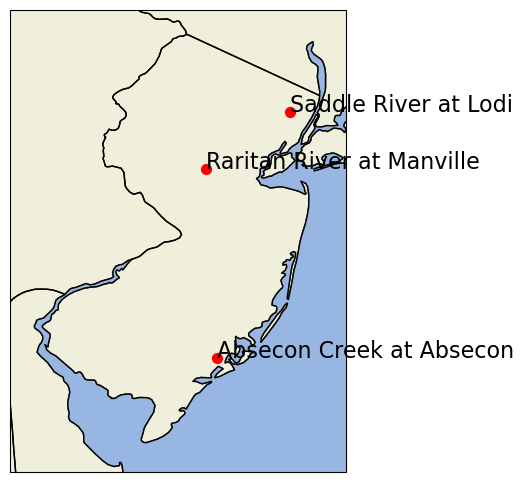

In [ ]:
%matplotlib inline
import cartopy.feature as cfeature

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN, edgecolor='none')

ax.set_extent([-75.75, -73.75, 38.75, 41.5])

ax.coastlines(resolution='10m', color = 'gray')
ax.add_feature(ccrs.cartopy.feature.STATES)

ax.scatter(-74.5828, 40.5556, color='red', s=50, transform=ccrs.PlateCarree())
ax.text(-74.5828, 40.5556, 'Raritan River at Manville', color='black', fontsize=16, transform=ccrs.PlateCarree())

ax.scatter(-74.5206, 39.4303, color='red', s=50, transform=ccrs.PlateCarree())
ax.text(-74.5206, 39.4303, 'Absecon Creek at Absecon', color='black', fontsize=16, transform=ccrs.PlateCarree())

ax.scatter(-74.0806, 40.8903, color='red', s=50, transform=ccrs.PlateCarree())
ax.text(-74.0806, 40.8903, 'Saddle River at Lodi', color='black', fontsize=16, transform=ccrs.PlateCarree())

fig.show()

### Plotting Daily Discharge Data

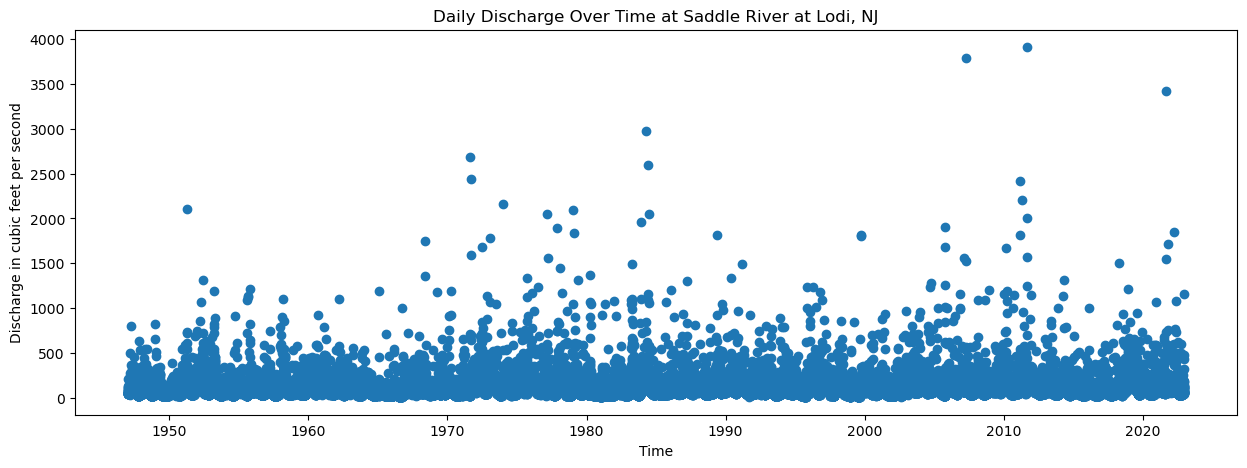

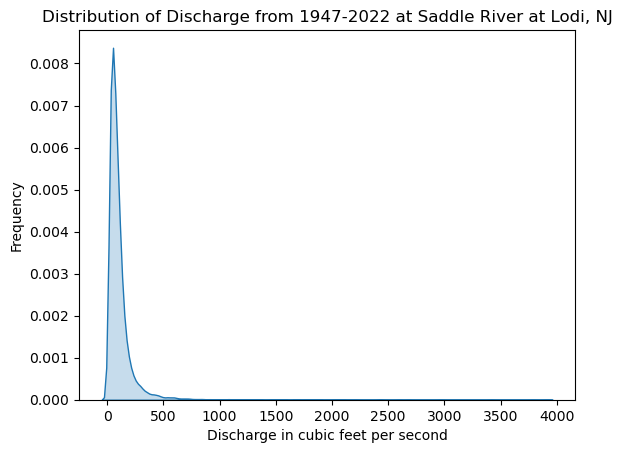

In [ ]:
plt.figure(figsize = (15, 5))
plt.scatter(sr_lodi_discharge.index, sr_lodi_discharge['discharge'])
plt.title("Daily Discharge Over Time at Saddle River at Lodi, NJ")
plt.xlabel("Time")
plt.ylabel("Discharge in cubic feet per second")

# To get a sense of the distribution of various discharge rates, I'll also create a density plot of the data
plt.figure()
sns.kdeplot(sr_lodi_discharge['discharge'],shade=True)
plt.title("Distribution of Discharge from 1947-2022 at Saddle River at Lodi, NJ")
plt.ylabel("Frequency")
plt.xlabel("Discharge in cubic feet per second")
plt.show()

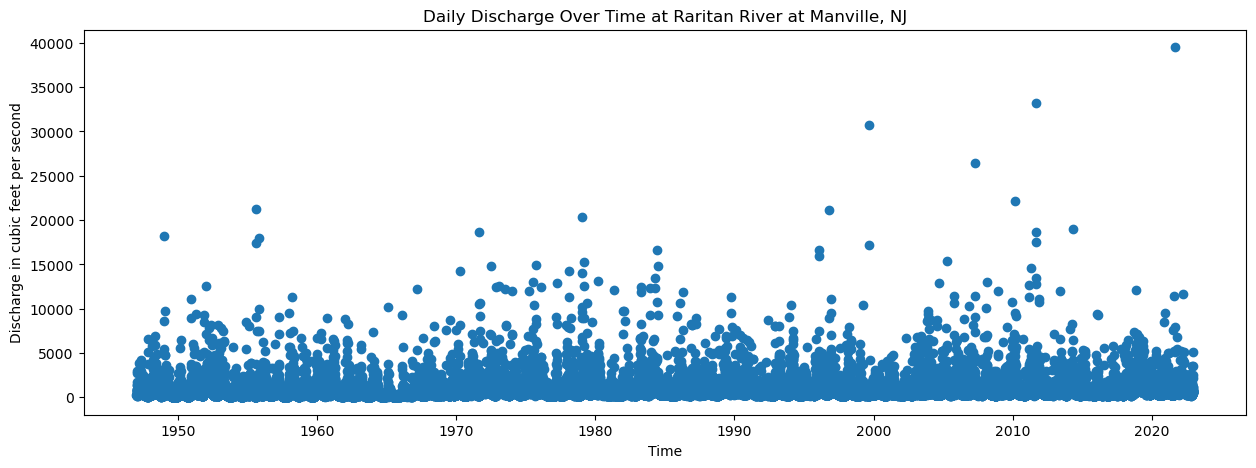

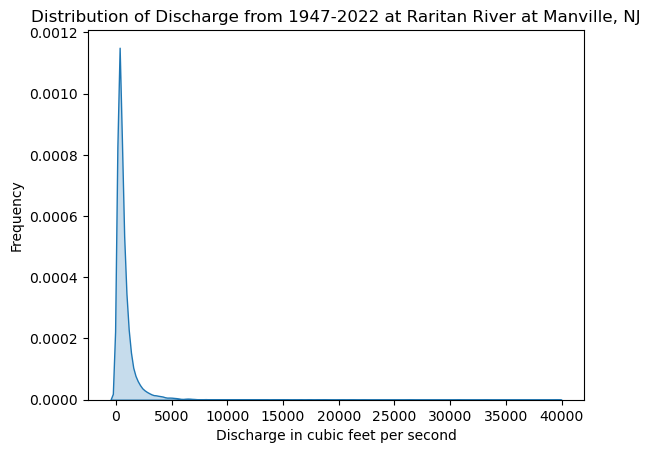

In [ ]:
plt.figure(figsize = (15, 5))
plt.scatter(rr_manville_discharge.index, rr_manville_discharge['discharge'])
plt.title("Daily Discharge Over Time at Raritan River at Manville, NJ")
plt.xlabel("Time")
plt.ylabel("Discharge in cubic feet per second")

# To get a sense of the distribution of various discharge rates, I'll also create a density plot of the data
plt.figure()
sns.kdeplot(rr_manville_discharge['discharge'],shade=True)
plt.title("Distribution of Discharge from 1947-2022 at Raritan River at Manville, NJ")
plt.ylabel("Frequency")
plt.xlabel("Discharge in cubic feet per second")
plt.show()

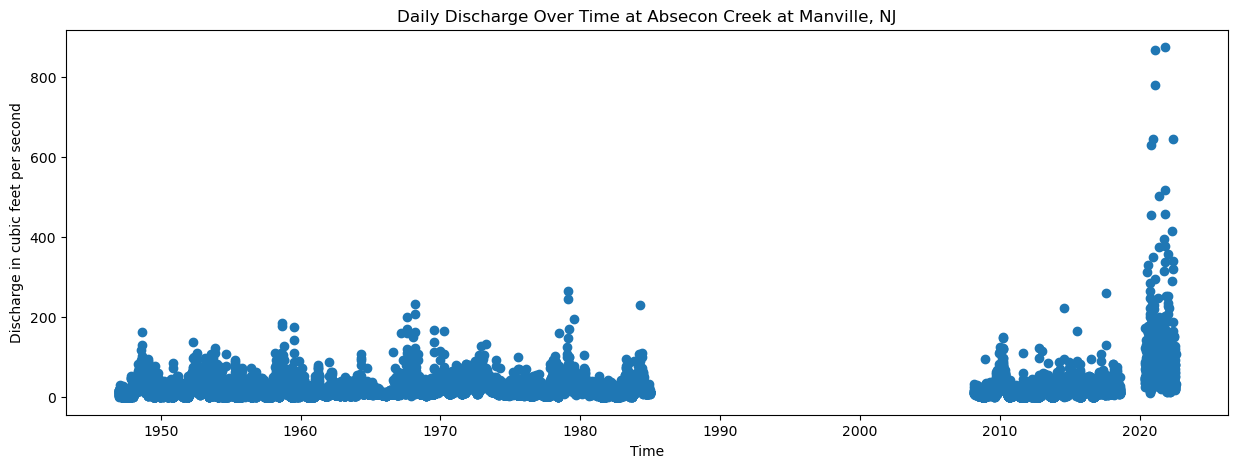

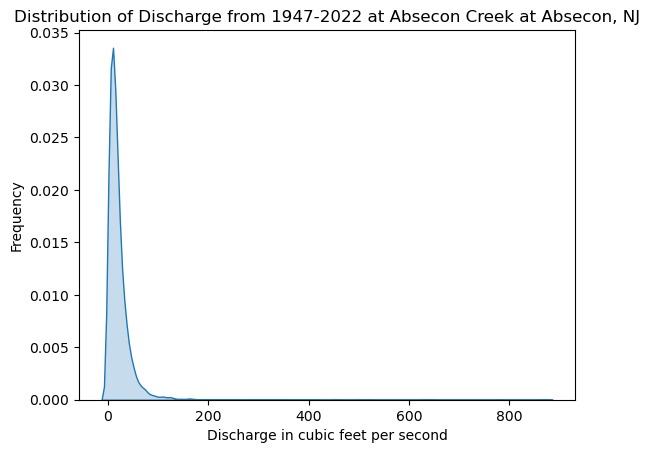

In [ ]:
plt.figure(figsize = (15, 5))
plt.scatter(ac_absecon_discharge.index, ac_absecon_discharge['discharge'])
plt.title("Daily Discharge Over Time at Absecon Creek at Manville, NJ")
plt.xlabel("Time")
plt.ylabel("Discharge in cubic feet per second")

# To get a sense of the distribution of various discharge rates, I'll also create a density plot of the data
plt.figure()
sns.kdeplot(ac_absecon_discharge['discharge'],shade=True)
plt.title("Distribution of Discharge from 1947-2022 at Absecon Creek at Absecon, NJ")
plt.ylabel("Frequency")
plt.xlabel("Discharge in cubic feet per second")
plt.show()

# Preparation of Data for Analysis

To prepare for the frequency analysis, for each station I will filter the mean daily discharge data and create a new dataframe with three columns: one containing the year, and the second containing the maximum annual mean daily discharge for that year.

Note that some of the datasets have gaps, and any years with missing data will be excluded from the final calculation for each station.

In [ ]:
sr_freq_analysis_df = pd.DataFrame({'year':[], 'max_mean':[]})

for year in range(1947, 2023):
    if year in [x.year for x in list(sr_lodi_discharge.index)]:
        sr_freq_analysis_df.loc[len(sr_freq_analysis_df.index)] = [year, sr_lodi_discharge.loc[sr_lodi_discharge.index.year == year, 'discharge'].max()]

sr_freq_analysis_df.head()

,year,max_mean
0,1947.0,795.0
1,1948.0,826.0
2,1949.0,651.0
3,1950.0,543.0
4,1951.0,2110.0


In [ ]:
rr_freq_analysis_df = pd.DataFrame({'year':[], 'max_mean':[]})

for year in range(1947, 2023):
    if (year in [x.year for x in list(rr_manville_discharge.index)]):
        rr_freq_analysis_df.loc[len(rr_freq_analysis_df.index)] = [year, rr_manville_discharge.loc[rr_manville_discharge.index.year == year, 'discharge'].max()]

rr_freq_analysis_df.head()

,year,max_mean
0,1947.0,6610.0
1,1948.0,18200.0
2,1949.0,9800.0
3,1950.0,11100.0
4,1951.0,12600.0


In [ ]:
ac_freq_analysis_df = pd.DataFrame({'year':[], 'max_mean':[]})

for year in range(1947, 2023):
    if year in [x.year for x in list(ac_absecon_discharge.index)]:
        ac_freq_analysis_df.loc[len(ac_freq_analysis_df.index)] = [year, ac_absecon_discharge.loc[ac_absecon_discharge.index.year == year, 'discharge'].max()]

ac_freq_analysis_df.head()

# A significant portion of the maximum annual instantaneous discharge data for this station is missing

,year,max_mean
0,1947.0,52.0
1,1948.0,162.0
2,1949.0,96.0
3,1950.0,85.0
4,1951.0,54.0


# Data Analysis & Plots

To calculate the exceedance probabilities and recurrence intervals, I will fit each mean daily dataset to a log-normal distribution, which is suitable for right-skewed data sets (and seen from the density function plots of each of the daily mean discharge distributions, all three stations' discharge distributions are right-skewed) and use that distribution to estimate the probability of each maximum mean daily and maximum instantaneous average streamflow occurring. The recurrence interval of each annual maximum discharge is simply the inverse of the exceedance probability (expressed as a percentage) at each station.

In [ ]:
import scipy.stats as stats

sr_lognorm_dist = stats.lognorm(*stats.lognorm.fit(sr_lodi_discharge['discharge']))
sr_exceedance_probabilities = (1 - sr_lognorm_dist.cdf(sr_freq_analysis_df['max_mean'])) * 100
sr_recurrence_intervals = 1/sr_exceedance_probabilities
sr_recurrence_intervals

array([5.54309194e+00, 6.42895401e+00, 2.63639381e+00, 1.40510410e+00,
       4.49614494e+02, 4.47730050e+01, 2.91902890e+01, 9.31430817e+00,
       3.14109627e+01, 1.86408850e+00, 5.35778290e+00, 2.07573392e+01,
       1.75739510e+00, 9.73539332e+00, 5.41019601e+00, 2.07573392e+01,
       1.47589039e+00, 1.33711654e+00, 2.91902890e+01, 1.38849111e+01,
       3.80944438e+00, 1.75269787e+02, 2.81305009e+01, 2.91902890e+01,
       1.60699322e+03, 1.43606340e+02, 5.07597169e+02, 6.61329104e+00,
       4.96118278e+01, 3.37722592e+01, 3.87613643e+02, 7.13219732e+01,
       4.28066551e+02, 5.48854781e+01, 1.70325015e+01, 1.91929711e+01,
       3.08383493e+02, 2.84536852e+03, 1.84486735e+01, 3.02834894e+01,
       4.32514535e+01, 4.95343172e+00, 2.12701975e+02, 4.96118278e+01,
       8.09921880e+01, 5.70613019e+00, 8.40310429e+00, 5.38393657e+00,
       3.50078930e+01, 3.50078930e+01, 7.70753256e+00, 7.22625724e+00,
       2.12701975e+02, 3.57923832e+00, 1.05333747e+01, 3.41422909e+00,
      

[26.107804579419064, 17, 6, 5]


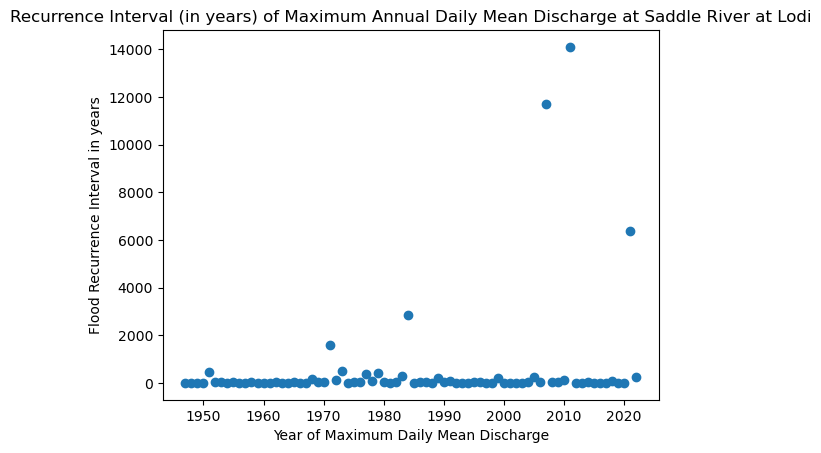

In [ ]:
plt.scatter(x=sr_freq_analysis_df['year'], y=sr_recurrence_intervals)
plt.title("Recurrence Interval (in years) of Maximum Annual Daily Mean Discharge at Saddle River at Lodi")
plt.xlabel("Year of Maximum Daily Mean Discharge")
plt.ylabel("Flood Recurrence Interval in years")

sr_over_100 = len([x for x in sr_recurrence_intervals if x >= 100])
sr_over_500 = len([x for x in sr_recurrence_intervals if x >= 500])
sr_over_1000 = len([x for x in sr_recurrence_intervals if x >= 1000])
print([np.median(sr_recurrence_intervals), sr_over_100, sr_over_500, sr_over_1000])

In [ ]:
rr_lognorm_dist = stats.lognorm(*stats.lognorm.fit(rr_manville_discharge['discharge']))
rr_exceedance_probabilities = (1 - rr_lognorm_dist.cdf(rr_freq_analysis_df['max_mean'])) * 100
rr_recurrence_intervals = 1/rr_exceedance_probabilities
rr_recurrence_intervals

rr_over_100 = len([x for x in rr_recurrence_intervals if x >= 100])
rr_over_500 = len([x for x in rr_recurrence_intervals if x >= 500])
rr_over_1000 = len([x for x in rr_recurrence_intervals if x >= 1000])
print([np.median(rr_recurrence_intervals), rr_over_100, rr_over_500, rr_over_1000])

[15.71999194534962, 12, 4, 3]


Text(0, 0.5, 'Flood Recurrence Interval in years')

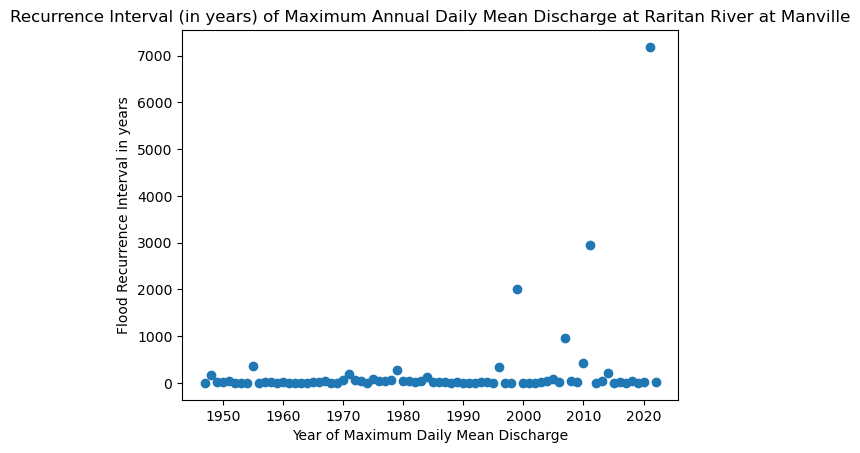

In [ ]:
plt.scatter(x=rr_freq_analysis_df['year'], y=rr_recurrence_intervals)
plt.title("Recurrence Interval (in years) of Maximum Annual Daily Mean Discharge at Raritan River at Manville")
plt.xlabel("Year of Maximum Daily Mean Discharge")
plt.ylabel("Flood Recurrence Interval in years")

In [ ]:
ac_lognorm_dist = stats.lognorm(*stats.lognorm.fit(ac_absecon_discharge['discharge']))
ac_exceedance_probabilities = (1 - ac_lognorm_dist.cdf(ac_freq_analysis_df['max_mean'])) * 100
ac_recurrence_intervals = 1/ac_exceedance_probabilities
ac_recurrence_intervals

array([1.30958124e-01, 3.52666932e+00, 6.27015854e-01, 4.42130584e-01,
       1.42245323e-01, 2.04767225e+00, 1.35711022e+00, 9.21877119e-01,
       5.71321043e-01, 3.04078493e-01, 1.15380790e-01, 5.91996203e+00,
       4.79699440e+00, 2.93499383e-01, 3.74201397e-01, 5.03374328e-01,
       1.20398798e-01, 9.21877119e-01, 7.37907456e-02, 1.03246174e+00,
       7.85325685e+00, 1.45762539e+01, 3.94354996e+00, 3.77215288e+00,
       4.13856232e-01, 1.50840940e+00, 1.76112253e+00, 2.93499383e-01,
       7.08062448e-01, 2.73230040e-01, 4.27804465e-01, 3.37048899e+00,
       2.51700967e+01, 8.21159333e-01, 1.30958124e-01, 9.27348112e-02,
       6.07981870e-01, 1.38136908e+01, 6.07981870e-01, 1.43111964e+00,
       2.67278334e+00, 9.48569716e-01, 1.35711022e+00, 4.42130584e-01,
       1.21635701e+01, 3.85706181e+00, 6.25090945e-01, 2.35681494e+01,
       4.15234273e-01, 2.05399254e+03, 1.20768362e+04, 2.07186945e+03])

0.9218771185048094


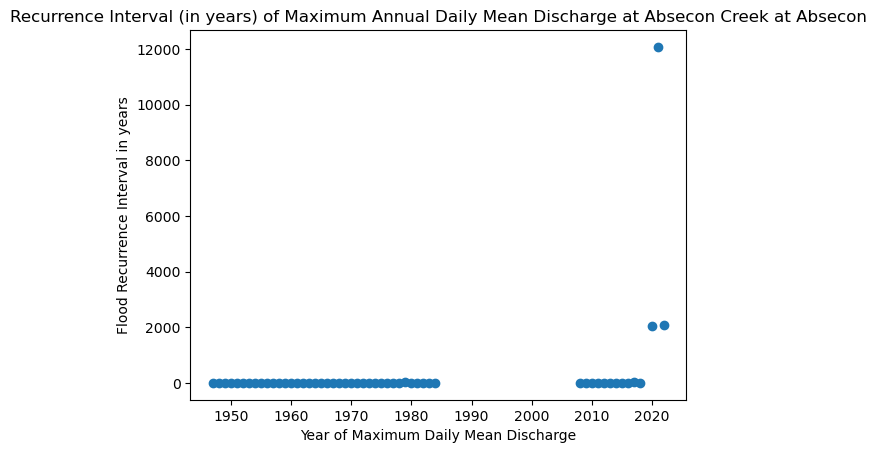

In [ ]:
plt.scatter(x=ac_freq_analysis_df['year'], y=ac_recurrence_intervals)
plt.title("Recurrence Interval (in years) of Maximum Annual Daily Mean Discharge at Absecon Creek at Absecon")
plt.xlabel("Year of Maximum Daily Mean Discharge")
plt.ylabel("Flood Recurrence Interval in years")
print(np.median(ac_recurrence_intervals))

# Results & Final Probability Calculations

In order to calculate the recurrence intervals of the maximum annual mean daily discharge at three New Jersey hydrologic stations, I filtered the annual maxima from each station's dataset, fit the entire dataset to a log-normal distribution (a reasonable distribution to choose since my plots of the data revealed that all their distributions are right-skewed), and then used the fitted distribution to calculate the exceedance probability of each annual maximum mean daily water discharge, which I could take the inverse of to determine the expected recurrence interval of each annual maximum mean daily water discharge (or in other words, the most significant flooding event recorded by the station that year).

Before examining the results, it is important to note that there are some flaws with my approach that may need to be corrected or reexamined in the future. Firstly, due to limitations on data, I only analyzed three stations of 75-year time intervals. Ideally, the time interval would be much longer so that the range of natural variability in flood events can be better captured in the fitted distribution, and more stations should be analyzed to better represent the geography and hydrology of the region being analyzed. Additionally, fitting the data to a log-normal distribution is a fairly crude approximation, as there exist more advanced statistical techniques to determine the exceedance probability of various stream flow discharges based on a distribution. Unfortunately, those advanced approaches are currently beyond my capabilities as a first-year undergraduate.

The median recurrence interval of the most significant flood event each year from 1947 to 2022 at the Saddle River at Lodi was 26.1 years. The Saddle River at Lodi also experienced 17 flood events with recurrence intervals greater than or equal to 100 years in the 75-year timespan we assessed, including 6 flood events with recurrence intervals greater than or equal to 500 years, and 5 flood events with recurrence intervals greater than or equal to 1000 years. The probability of 5 1000-year floods alone occurring in a 75-year timespan is 1.6 * 10^(-6)%, based on the binomial probability formula.

The median recurrence interval of the most significant flood event each year from 1947 to 2022 at the Raritan River at Manville was 25.7 years. The Saddle River at Lodi also experienced 12 flood events with recurrence intervals greater than or equal to 100 years in the 75-year timespan we assessed, including 4 flood events with recurrence intervals greater than or equal to 500 years, and 3 flood events with recurrence intervals greater than or equal to 1000 years. The probability of 8 100-year floods, 1 500-year flood, and 3 1000-year floods occurring in a 75-year timespan is roughly 6.99 * 10^(-10)%, based on the binomial probability formula.

The median recurrence interval of the most significant flood event each year from 1947 to 2022 at the Absecon Creek at Absecon Creek was 0.92 years. The Absecon Creek also experienced 3 flood events with recurrence intervals greater than or equal to 1000 years, all of which occurred in the last decade of the analyzed time interval. The probability of three 1000-year floods occurring within a decade is 1.19 * 10^(-7)%, based on the binomial probability formula.

The analysis of this hydrological data reveals a pattern of increasingly and unusually frequent anomalous flood events in New Jersey that is not typical of our climate's natural range of variability. Though this data analysis cannot provide insight into the causes of this unusual pattern (and there is always a small possibility that the pattern is caused by natural variability), the finding of increasingly frequent extreme flooding events suggests that New Jersey's climate is fundamentally changing.

# Footnotes

These footnotes are not formatted and simply take the form of web links, since they were not required for the project. I included them to increase clarity about where each source is used in this project, and make these sources are easily accessible.

1. https://www.weather.gov/ffc/flood_awareness_flooding#:~:text=Floods%20occur%20nationwide%20and%20are,from%20flash%20and%20river%20floods.
2. https://maps.waterdata.usgs.gov/mapper/index.html
3. https://pypi.org/project/hydrofunctions/
4. https://pubs.usgs.gov/tm/04/b05/tm4b5.pdf
5. https://www.usgs.gov/special-topics/water-science-school/science/100-year-flood#science

# Works Cited

1. “The 100-Year Flood.” The 100-Year Flood, 2023, www.usgs.gov/special-topics/water-science-school/science/100-year-flood#science.

2. “Flood Preparedness Week - Flooding and Related Phenomena.” National Weather Service, 16 July 2015, www.weather.gov/ffc/flood_awareness_flooding#:~:text=Floods%20occur%20nationwide%20and%20are,from%20flash%20and%20river%20floods.

3. “Hydrofunctions Documentation.” PyPI, 2023, pypi.org/project/hydrofunctions/.

4. U.S. Department of the Interior, pp. 5–30, Guidelines for Determining Flood Flow Frequency Bulletin 17C.

5. Water Resources of the United States-National Water Information System (NWIS) Mapper, 2023, maps.waterdata.usgs.gov/mapper/index.html.

# Final Acknowledgements

I would like to acknowledge Prof. Swanson-Hysell and the EPS 88 course staff for teaching us the skills to make this project possible. I would also like to acknowledge Prof. Stolper of my EPS 50 class this semester, as his discussion of recurrence intervals of floods and hydrology in class inspired me to choose those topics for this project.